# first time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [4]:
def back_y_log(y):
    return np.exp(np.array(y))

In [6]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [5]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [8]:
def claculate_metrics_model_reg(y, y_pred, model_params):
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_arma_metric = {}
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T,
                        columns=['r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [9]:
def claculate_metrics_model(y, y_pred, p, q, weight, window, params_ar, params_ma, intercept):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid'] / len(y)) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [10]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

In [11]:
def show_prediction(y, y_pred, name):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y)
    plt.plot(y_pred)

## ARMA

In [12]:
file1 = open('2006rts1.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
(len(y))

248

## Зобразимо описові характеристики ряду

In [13]:
lags=40
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 248,
 'mode': 1190.34,
 'mean': 1545.9118951612907,
 'median': 1552.115,
 'variation': 24453.166410563863,
 'skewness': 0.1420579833187732,
 'kurtosis': -0.44372227972289036,
 'jarque-bera': 3.000356221871671,
 'probability': 0.22309042176581806}

In [14]:
y = pd.Series(y)
y.describe()

count     248.000000
mean     1545.911895
std       156.375082
min      1190.340000
25%      1429.807500
50%      1552.115000
75%      1641.837500
max      1921.920000
dtype: float64

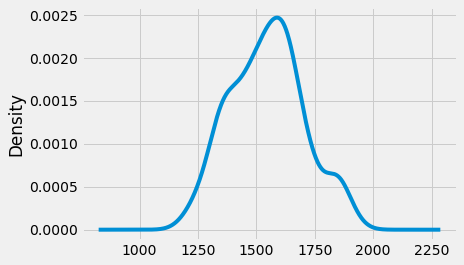

In [15]:
y.plot(kind='kde')

## Прологарифмуємо ряд

In [16]:
y = np.log(y)
y = pd.Series(y)

In [17]:
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 248,
 'mode': 7.081994259582736,
 'mean': 7.338256943811091,
 'median': 7.347373779077963,
 'variation': 0.01030062937038089,
 'skewness': -0.08793388111881964,
 'kurtosis': -0.47645363989598843,
 'jarque-bera': 2.806895389208736,
 'probability': 0.24574823683620872}

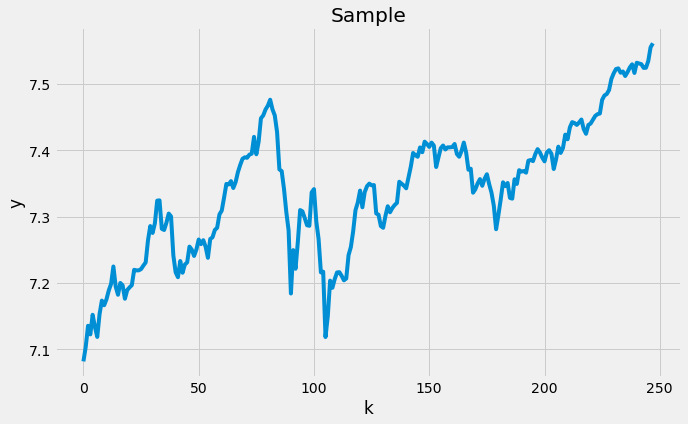

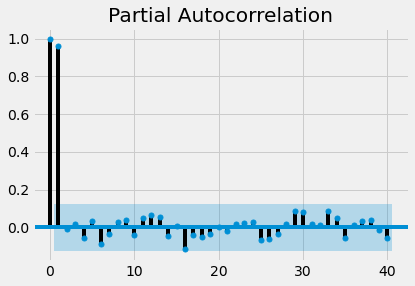

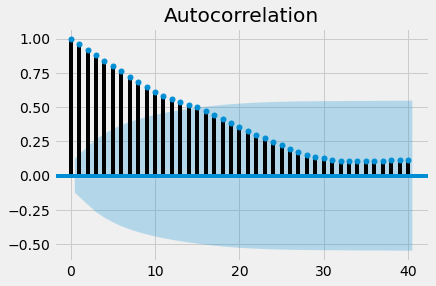

In [18]:
calculate_metrics_sample(y)
show_plots(y)

Із значення автокореляції обираємо p = 15

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [19]:
model = ARIMA(y, order=(15,0,0))
model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  248
Model:                    ARMA(15, 0)   Log Likelihood                 622.955
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 04 Nov 2020   AIC                          -1211.910
Time:                        13:40:12   BIC                          -1152.182
Sample:                             0   HQIC                         -1187.866
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3309      0.124     58.980      0.000       7.087       7.574
ar.L1.y        1.0489      0.063     16.562      0.000       0.925       1.173
ar.L2.y       -0.0113      0.091     -0.124      0.9

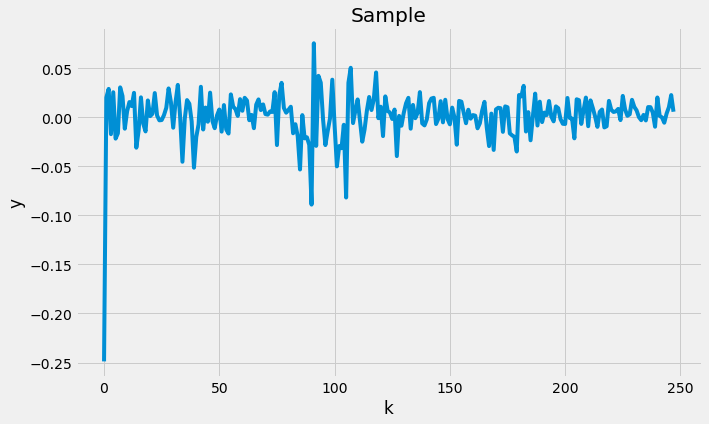

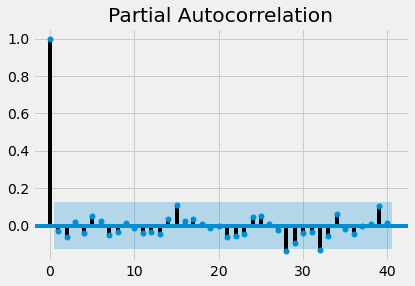

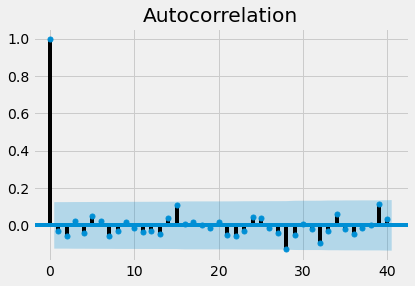

In [20]:
res =  model_fit.resid
show_plots(res)

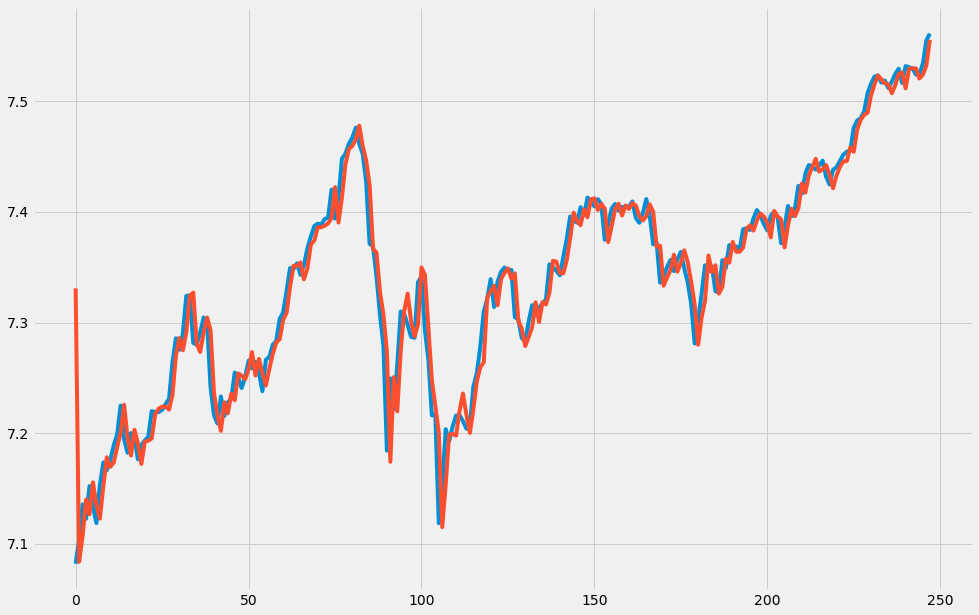

In [21]:
plt.figure(figsize= (15,10))

plt.plot(y)
plt.plot(np.array(model_fit.predict()))

In [25]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model = []

p, q = 15,32

mv5_simple = weight(res, weight='simple',window=5)
mv10_simple = weight(res, weight='simple',window=10)
mv5_epx = weight(res, weight='exponential',window=5)
mv10_epx = weight(res, weight='exponential',window=10)

# we log input series and now come back to input series
y_back = back_y_log(y)

# create prediction and parametrs
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple, mv5_simple)

# back prediction to input series take exp()
pred_back = back_y_log(pred) 

# calculate metrics for real time series
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)


pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple, mv10_simple)
pred_back = back_y_log(pred) 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_epx, mv5_epx)
pred_back = back_y_log(pred) 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_epx, mv10_epx)
pred_back = back_y_log(pred) 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)


## зообразимо отримані метрики готових моделей

In [26]:
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((15, 32)) simple:5",0.950636,298154,1852.8,1.62643,"[[1.0409785754881546], [0.006079598611043137],...","[[0.9223433926828898], [0.04680315550223072], ...",[0.10100290630169612]
1,"ARMA((15, 32)) simple:10",0.950319,300073,1854.39,1.64496,"[[1.0404188748681162], [-0.0024817125027411925...","[[0.9502719485838836], [0.05874993580394858], ...",[0.11112420008552217]
2,"ARMA((15, 32)) exponential:5",0.951546,292658,1848.19,1.61262,"[[1.1910223219448606], [-0.06173194780092641],...","[[0.6268701883143453], [0.007210333309477523],...",[0.08645091821073612]
3,"ARMA((15, 32)) exponential:10",0.950927,296395,1851.33,1.64079,"[[1.0826894324427436], [-0.009404285324468749]...","[[0.770588835156545], [0.049319844621282555], ...",[0.09933914687118782]


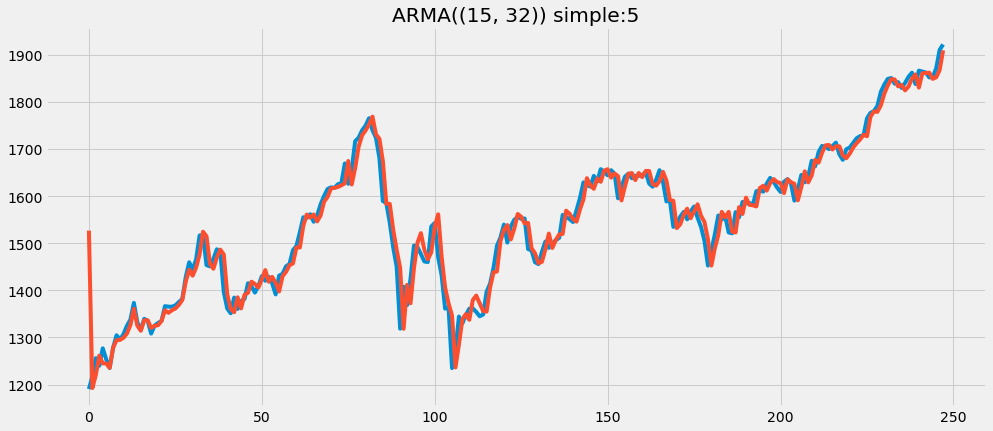

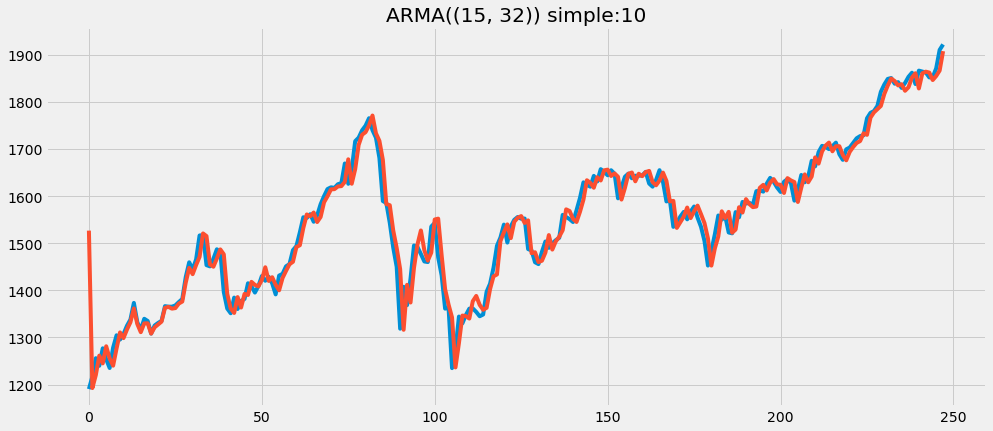

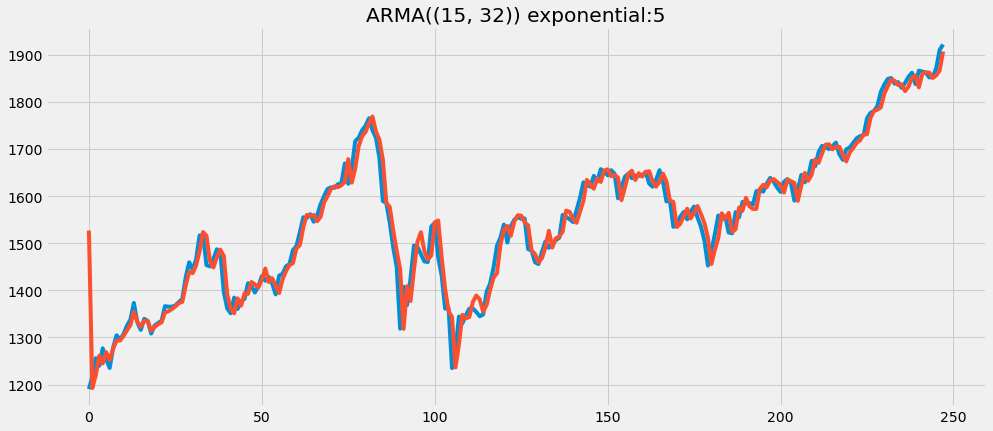

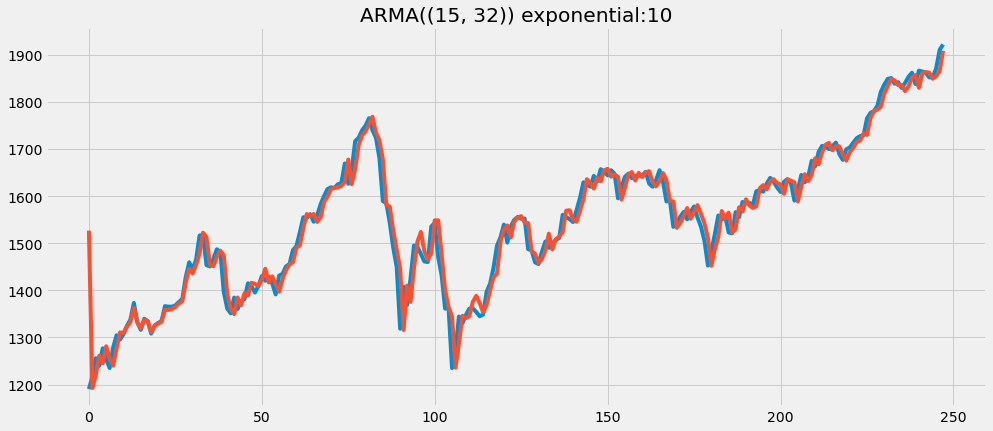

In [27]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y_back, y_pred, name)

In [24]:
models_metrics.to_excel('result/table_1.xls')

## 2. Побудова ARMA(p,q) коли КС будується по вихідному сигналу у 

## Власні коефіцієнти

In [50]:
def know_b(y, mv,q, window):
    a = 2/(window+1)
    s = sum([(1-a)**i for i in range(1, q+1)])
    b = [(1/s)*((1-a)**i) for i in range(1, q+1)]
    y_new = []
    for i in range(len(y)):
        s = y[i]-mv[i]
        
        for j in range(q):
            if( i - j -1 > -1):
                s += -mv[i-j-1]*b[j]
        y_new.append(s)
        
    return y_new, b

## продиференціюємо ряд, оскільки метод не працює з нестаціонарним рядо

In [252]:
def ARMA(p, q, y_, res_, b=None):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    #----------------
    res = pd.DataFrame(list(res_), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
#     res_train_2 = res.fillna(0)
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    if b is None:
        lr = LinearRegression()
        lr.fit(X_train_ma,y_train_ma)

        theta_ma  = lr.coef_.T
        intercept_ma = lr.intercept_
    else:
        theta_ma = np.array(b)
        intercept_ma = 0

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma

    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
#     pred = list(prediction['Predicted_Values'])
    prediction = prediction.dropna()
    pred = [x for x in y_[:max(p,q)]] + list(prediction.Predicted_Values)

    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

In [90]:
def adf_check(time_series):
    """
    Pass in a time series, return ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [268]:
def back_y_diff(y_old, y, pred):
    df = pd.DataFrame({'Value': y_old})
    df_c = pd.DataFrame({'Value': y, 'Predicted_Value': pred}).dropna()

    df_c.Value += df.shift(1).Value
    df_c.Value += df.diff().shift(1).Value
    df_c.Predicted_Value += df.shift(1).Value
    df_c.Predicted_Value += df.diff().shift(1).Value

    df_c = df_c.dropna()
    
    return y_old[len(y_old) - len(df_c.Value):], df_c.Value, df_c.Predicted_Value

In [317]:
file1 = open('2006rts1.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

diff_y = pd.DataFrame(y).diff().diff(1).dropna()

# test = sm.tsa.adfuller(diff_y)
# print(f'test:\n{test}')
y_old = y
# y = np.array(diff_y.values)
y = np.array(diff_y).reshape(1,-1)[0]
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 246,
 'mode': -5.770000000000209,
 'mean': -0.05967479674796774,
 'median': -0.7599999999999909,
 'variation': 1600.80325213871,
 'skewness': 0.6919823398936111,
 'kurtosis': 4.703590507825197,
 'jarque-bera': 234.79971317854233,
 'probability': 0.0}

In [318]:
adf_check(y)

Augmented Dickey-Fuller Test
ADF Test Statistic : -7.456112348484495
p-value : 5.506908558062032e-11
Number of Lags Used : 15
Number of Observations Used : 230
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


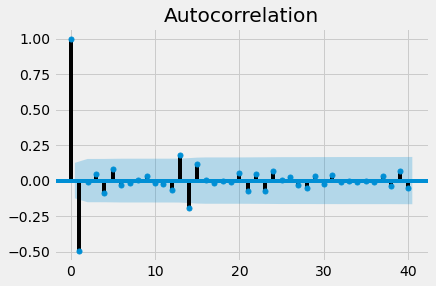

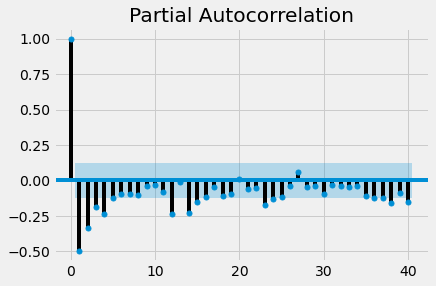

In [319]:
plot_acf(y, lags=lags);
plot_pacf(y, lags=lags);

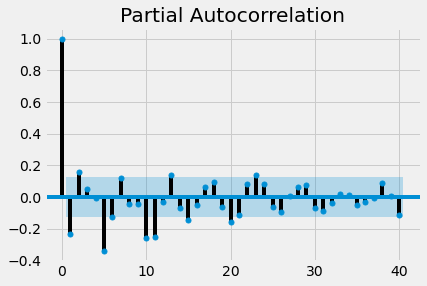

In [320]:
models_metrics_1 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_aprox = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_1 = []

window = 5
mv5_simple = weight(pd.DataFrame(y), weight='simple',window=window)

plot_pacf(pd.Series(mv5_simple[0]), lags=lags);

In [321]:
p,q=14, 23
y_new2, b2 = know_b(y, mv5_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_simple[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 23)) simple:5",0.799224,1.12847e+06,2133.17,1.27452,"[[-0.653923352161439], [-0.5163798305582664], ...","[0.33336303757615526, 0.2222420250507702, 0.14...",[0.7560363316497196]


In [322]:
# plt.figure(figsize=(15,7.5))
# plt.plot(y_aprox, color='blue')
# plt.plot(pred, color='yellow')
# plt.plot(y_real, color='red')

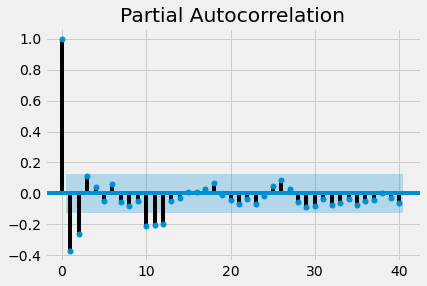

In [323]:
window = 10
mv10_simple = weight(pd.DataFrame(y), weight='simple',window=window)
plot_pacf(mv10_simple, lags=lags);

In [324]:
q=13
y_new2, b2 = know_b(y, mv10_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_simple[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 13)) simple:10",0.782281,1.2237e+06,2132.93,1.17444,"[[-0.7312722439293479], [-0.5710929789823207],...","[0.19626925102291018, 0.1605839326551083, 0.13...",[0.24501870661969344]


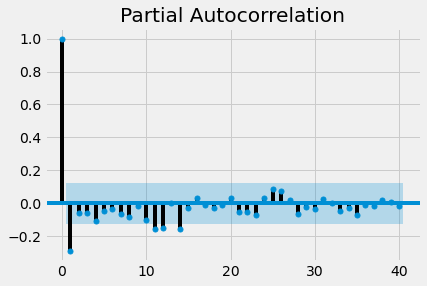

In [325]:
window = 5
mv5_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv5_exp, lags=lags);

In [326]:
q=14
y_new2, b2 = know_b(y, mv5_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_exp[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 14)) exponential:5",0.813911,1.04592e+06,2096.63,1.2639,"[[-0.7470219035680351], [-0.6276643056405505],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[0.6444760865532649]


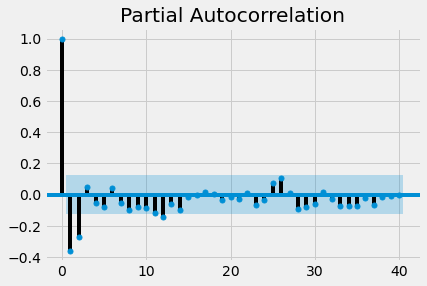

In [327]:
window = 10
mv10_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv10_exp, lags=lags);

In [328]:
q=12
y_new2, b2 = know_b(y, mv10_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_exp[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 12)) exponential:10",0.787127,1.19646e+06,2125.44,1.18426,"[[-0.7819109233580619], [-0.6612031949526166],...","[0.1997981697968927, 0.16347122983382129, 0.13...",[0.3828540569925378]


## зообразимо отримані метрики готових моделей 
###  за y взяті реальні занчення

In [329]:
models_metrics_1

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 23)) simple:5",0.799224,1.12847e+06,2133.17,1.27452,"[[-0.653923352161439], [-0.5163798305582664], ...","[0.33336303757615526, 0.2222420250507702, 0.14...",[0.7560363316497196]
1,"ARMA((14, 13)) simple:10",0.782281,1.2237e+06,2132.93,1.17444,"[[-0.7312722439293479], [-0.5710929789823207],...","[0.19626925102291018, 0.1605839326551083, 0.13...",[0.24501870661969344]
2,"ARMA((14, 14)) exponential:5",0.813911,1.04592e+06,2096.63,1.2639,"[[-0.7470219035680351], [-0.6276643056405505],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[0.6444760865532649]
3,"ARMA((14, 12)) exponential:10",0.787127,1.19646e+06,2125.44,1.18426,"[[-0.7819109233580619], [-0.6612031949526166],...","[0.1997981697968927, 0.16347122983382129, 0.13...",[0.3828540569925378]


## зообразимо отримані метрики готових моделей 
### (за y взятий диференційоване занчення, тобто на якому будувалася модель)

In [330]:
predictions_model_aprox

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 23)) simple:5",0.954052,288838,1800.65,2.09416,"[[-0.653923352161439], [-0.5163798305582664], ...","[0.33336303757615526, 0.2222420250507702, 0.14...",[0.7560363316497196]
1,"ARMA((14, 13)) simple:10",0.959915,251982,1747.35,2.06928,"[[-0.7312722439293479], [-0.5710929789823207],...","[0.19626925102291018, 0.1605839326551083, 0.13...",[0.24501870661969344]
2,"ARMA((14, 14)) exponential:5",0.952251,300164,1792.04,2.16545,"[[-0.7470219035680351], [-0.6276643056405505],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[0.6444760865532649]
3,"ARMA((14, 12)) exponential:10",0.959242,256211,1749.41,2.09156,"[[-0.7819109233580619], [-0.6612031949526166],...","[0.1997981697968927, 0.16347122983382129, 0.13...",[0.3828540569925378]


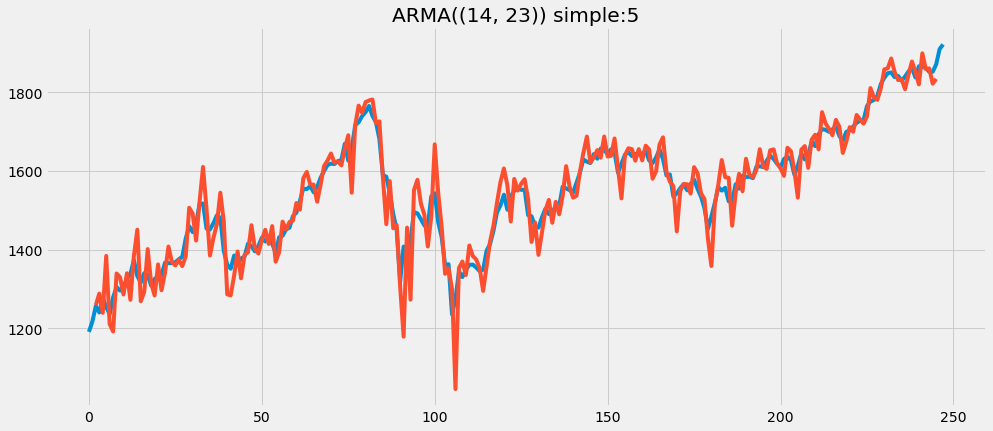

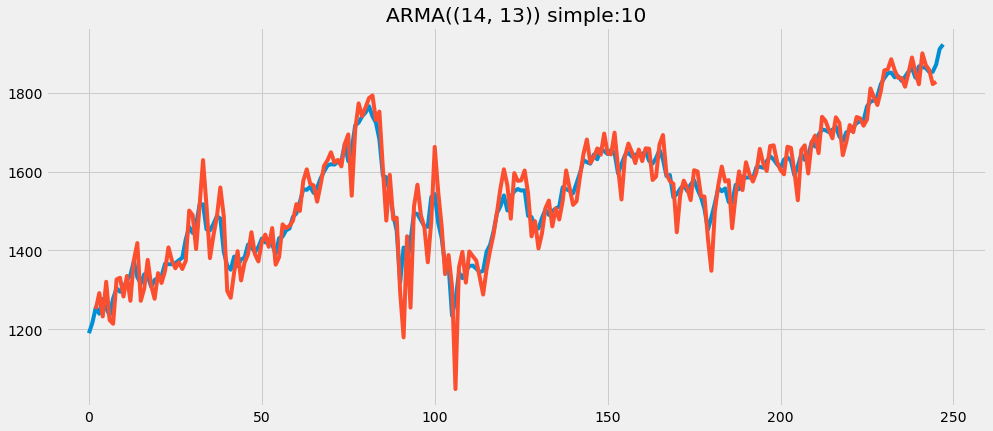

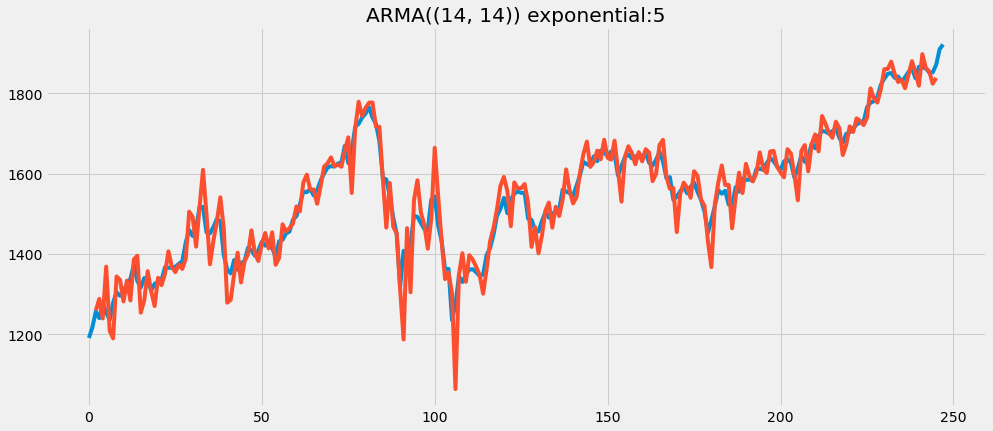

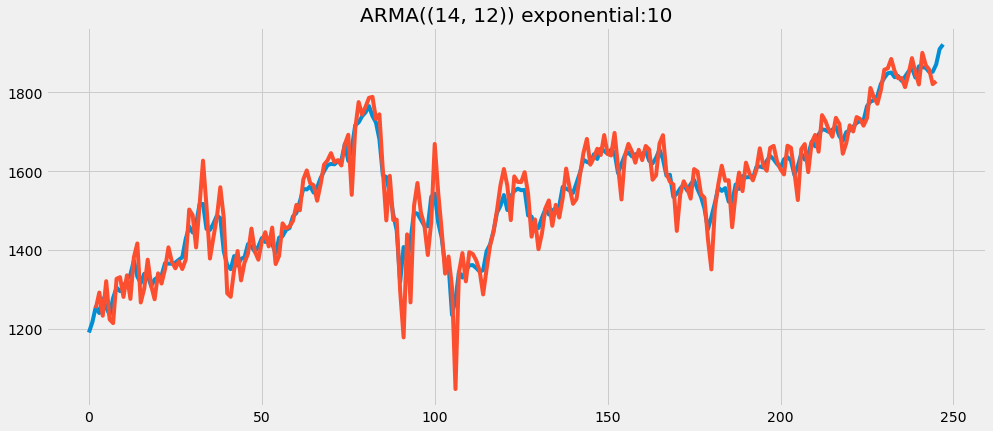

In [294]:
for name, y_pred in zip(models_metrics_1.name, predictions_model_1):
    show_prediction(y_old, y_pred, name)

In [333]:
models_metrics_1.to_excel('result/table_2.xls')
predictions_model_aprox.to_excel('result/table_2_aprox.xls')

## Обчислення коефіцієнтів 

In [339]:
models_metrics_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_aprox_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

predictions_model_2 = []

q = 23
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple[0], mv5_simple[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)


q = 13
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple[0], mv10_simple[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)

q = 14
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_exp[0], mv5_exp[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)

q = 12
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_exp[0], mv10_exp[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)

predictions_model_2.append(pred)

## зообразимо отримані метрики готових моделей
###  за y взяті реальні занчення

In [340]:
models_metrics_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 23)) simple:5",0.771225,1.28584e+06,2165.02,1.20279,"[[-0.9044660920737472], [-0.8989732308452253],...","[[0.07397229226079337], [0.0563332399196648], ...",[0.4070831639319921]
1,"ARMA((14, 13)) simple:10",0.770685,1.28887e+06,2145.6,1.15166,"[[-0.8279065619573239], [-0.7230040866293183],...","[[0.06963778403645225], [0.031487282263544095]...",[0.15437915981151756]
2,"ARMA((14, 14)) exponential:5",0.768668,1.30021e+06,2149.73,1.16953,"[[-1.0080819111921049], [-1.016992939663199], ...","[[-0.2206671668805478], [-0.20804795902863607]...",[0.2973671954459228]
3,"ARMA((14, 12)) exponential:10",0.768496,1.30118e+06,2145.91,1.14706,"[[-0.9027571308503083], [-0.8487810302752812],...","[[-0.07917659113887769], [-0.06067223878056715...",[0.18597368585520507]


## зообразимо отримані метрики готових моделей 
### (за y взятий диференційоване занчення, тобто на якому будувалася модель)

In [341]:
predictions_model_aprox_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((14, 23)) simple:5",0.964596,222560,1737.05,2.12228,"[[-0.9044660920737472], [-0.8989732308452253],...","[[0.07397229226079337], [0.0563332399196648], ...",[0.4070831639319921]
1,"ARMA((14, 13)) simple:10",0.963627,228650,1723.64,2.09958,"[[-0.8279065619573239], [-0.7230040866293183],...","[[0.06963778403645225], [0.031487282263544095]...",[0.15437915981151756]
2,"ARMA((14, 14)) exponential:5",0.965478,217014,1712.89,2.12609,"[[-1.0080819111921049], [-1.016992939663199], ...","[[-0.2206671668805478], [-0.20804795902863607]...",[0.2973671954459228]
3,"ARMA((14, 12)) exponential:10",0.964299,224424,1717.09,2.09947,"[[-0.9027571308503083], [-0.8487810302752812],...","[[-0.07917659113887769], [-0.06067223878056715...",[0.18597368585520507]


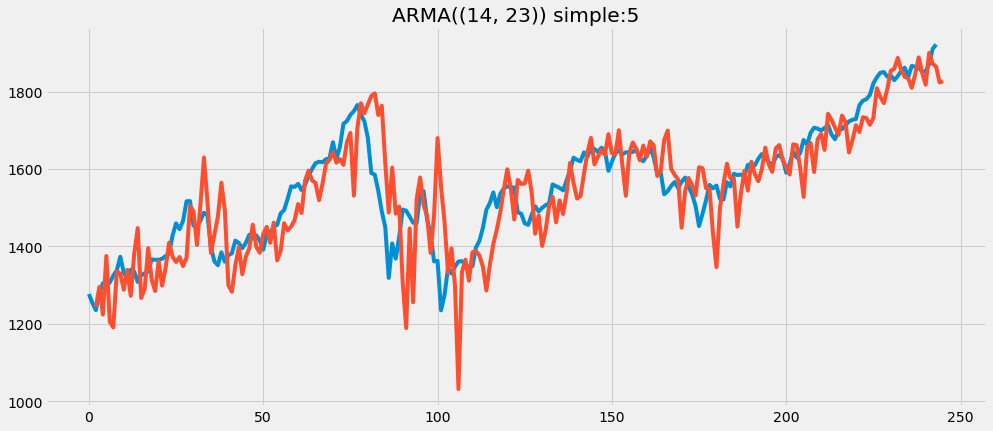

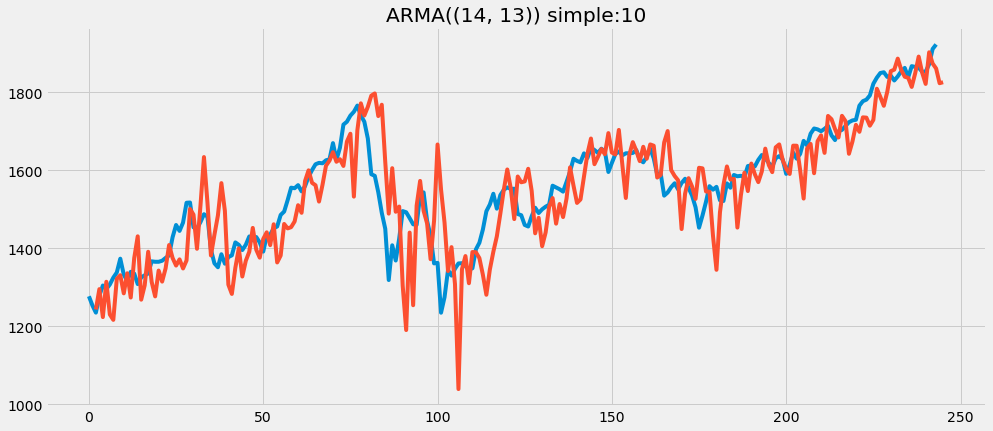

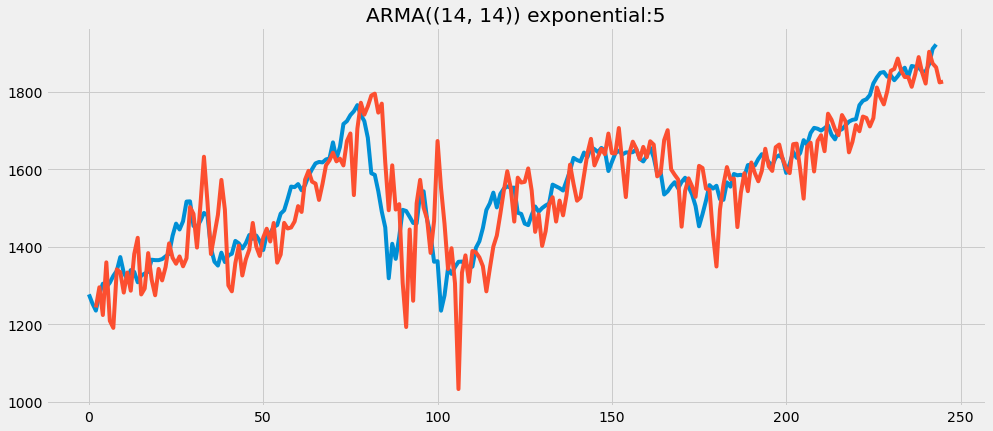

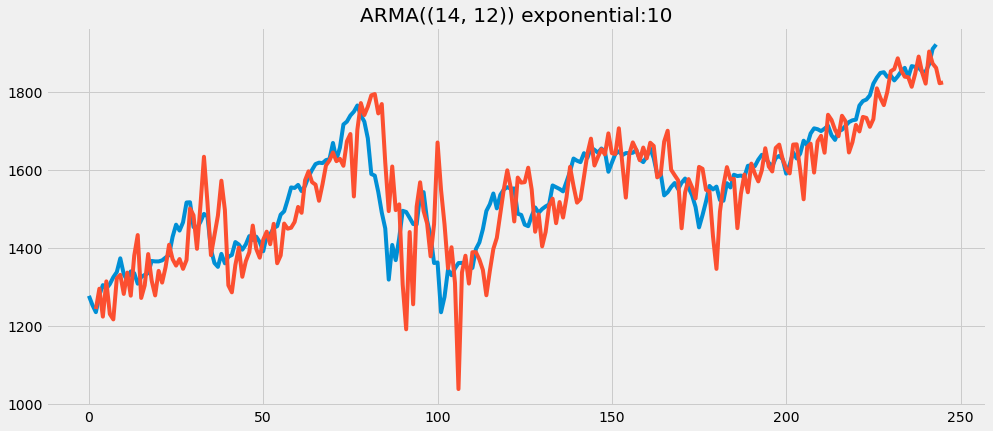

In [342]:
for name, y_pred in zip(models_metrics_2.name, predictions_model_2):
    show_prediction(y_real, y_pred, name)

In [343]:
models_metrics_2.to_excel('result/table_3.xls')
predictions_model_aprox_2.to_excel('result/table_3_aprox.xls')

# Multiple regression

In [303]:
df_train = pd.read_excel('ATS_lab_03_new/Data/xls/Full_Data.xls')

In [304]:
df_train.shape

(178, 10)

In [305]:
df_train.head()

,<DTYYYYMMDD>,RTSI,RTS2,RTSog,RTStl,RTSmm,RTSin,RTScr,RTSeu,RTSfn
0,20080109,2296.56,2632.20,288.90,322.85,363.97,408.62,374.12,465.29,786.31
1,20080110,2306.87,2642.20,289.56,322.59,368.81,409.33,376.17,463.22,788.79
2,20080111,2313.90,2651.62,289.20,324.09,369.50,413.30,380.34,463.92,792.27
3,20080114,2339.79,2652.71,293.30,328.12,376.52,414.34,382.76,465.09,796.21
4,20080115,2330.87,2670.61,291.39,328.72,376.05,417.96,386.37,468.23,793.43


In [306]:
df_train = df_train.drop(['<DTYYYYMMDD>'],axis=1)

In [307]:
df_train.describe()

,RTSI,RTS2,RTSog,RTStl,RTSmm,RTSin,RTScr,RTSeu,RTSfn
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,2043.537303,2383.844326,265.259888,262.411854,359.151966,392.829326,325.120730,352.207472,623.623652
std,289.921448,290.307690,39.371808,30.039644,57.078046,54.309037,33.461727,62.913200,88.704163
min,1058.840000,1441.950000,147.400000,158.390000,194.270000,246.140000,216.760000,169.920000,309.390000
25%,1947.650000,2396.500000,241.652500,258.902500,329.405000,378.690000,324.467500,312.975000,604.335000
50%,2068.170000,2483.955000,264.100000,269.525000,374.025000,414.835000,334.860000,362.815000,633.670000
75%,2220.542500,2576.405000,293.075000,278.355000,402.762500,430.002500,344.987500,403.910000,678.172500
max,2487.920000,2670.610000,334.230000,328.720000,442.990000,450.600000,386.370000,468.230000,796.210000


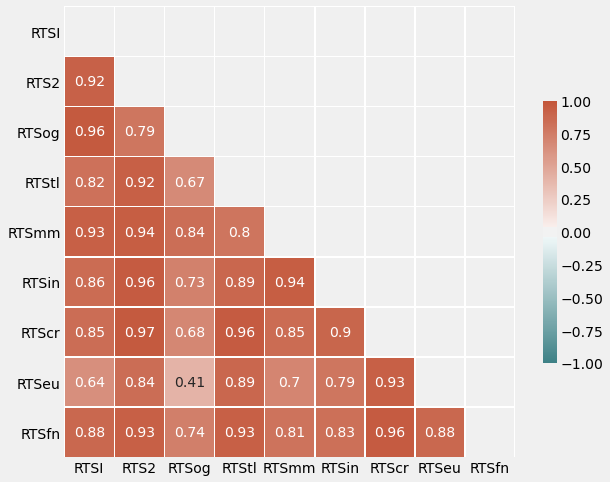

In [308]:
correlation = df_train.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9, 9))

cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5,cbar_kws={'shrink': .5}, annot=True)

plt.show()

## Оскільки всі регресори моделі мають високу кореляцію з 'rts1', використовуємо всі

In [309]:
rts1 = df_train.RTSI
df_train = df_train.drop(['RTSI'], axis=1)

In [310]:
reg = LinearRegression().fit(df_train.values, rts1)
pred = df_train.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rts1, pred, len(df_train.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.999301,10395.684492,1662.347996,0.472749


## Спробуємо покращити модель взявши логарифм

In [312]:
df_train_log = np.log(df_train)
rst1_log = np.log(rts1)

reg = LinearRegression().fit(df_train_log.values, rst1_log)
pred = df_train_log.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rts1, np.exp(pred), len(df_train_log.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.999203,11859.39747,1685.795904,0.456362


#### Бачимо що отримали кращі результати в метриках 

## Врахуємо залежність між попередніми координатами

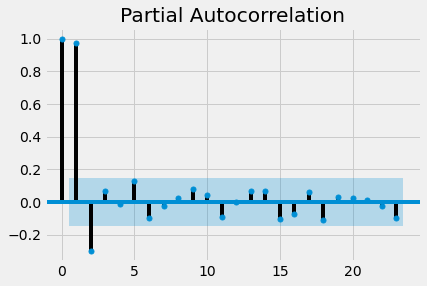

In [313]:
plot_pacf(rts1);

In [314]:
df_shift = df_train.copy()
p = 2
df_rts = pd.DataFrame(rts1, columns=['Value'])
for i in range(1,p+1):
        df_shift[f'Shifted_values_{i}'] = df_rts['Value'].shift(i)

df_shift = df_shift.fillna(0)
reg = LinearRegression().fit(df_shift.values, rts1)
pred = df_shift.dot(reg.coef_) + reg.intercept_
claculate_metrics_model_reg(rts1, pred, len(df_shift.columns))

,r_squared,sum_squared_resid,aic,durbin_watson
0,0.999301,10395.684492,1666.347996,0.472749


### Coefficients

In [55]:
print(f'intercept:\t{reg.intercept_:e}')
print(f'coeff: \n{reg.coef_ }')

intercept:	-5.026886e+01
coeff: 
[ 0.05360143  4.10400701  0.69963745  1.2086222  -0.19721911 -0.46968547
  0.02216155  0.77306325  0.          0.        ]
